In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import itertools
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn import svm,metrics
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Read all the csv

In [12]:
base_url = './Csvs/'
x_test = pd.read_csv(base_url + 'x_test.csv',header=None)
x_train = pd.read_csv(base_url + 'x_train.csv',header=None)
y_train = pd.read_csv(base_url + 'y_train.csv',header=None)
x_valid = pd.read_csv(base_url + 'x_valid.csv',header=None)
y_valid = pd.read_csv(base_url + 'y_valid.csv',header=None)

# Get All sample shapes
print("X_test shape : " + str(x_test.transpose().shape))
print("X_train shape : " + str(x_train.transpose().shape))
print("Y_train shape : " + str(y_train.shape))
print("X_valid shape : " + str(x_valid.transpose().shape))
print("y_valid shape : " + str(y_valid.shape))

X_test shape : (100, 30)
X_train shape : (50, 30)
Y_train shape : (50, 1)
X_valid shape : (50, 30)
y_valid shape : (50, 1)


# Data Balancing using undersampler

In [3]:
# Checking distribution of classes in the data
distribution=y_train.groupby(0).size().to_dict()
print("Before Resampling : "+ str(distribution))
# resampling the data using RandomUnderSampler
X_resampled, y_resampled = RandomUnderSampler(random_state=1).fit_resample(x_train.transpose(), y_train)

# Rechecking the distribution after under sampling
print("After Resampling : " + str(y_resampled.groupby(0).size().to_dict()))

Before Resampling : {0.0: 28, 1.0: 22}
After Resampling : {0.0: 22, 1.0: 22}


# Assigning Training,Validation and Test sets

In [6]:
# Assigning X_train,Y_train,X_valid,Y_valid
X_train,y_train=X_resampled, y_resampled
X_valid,y_valid =x_valid.transpose(),y_valid
X_test=x_test.transpose()

# Checking co-relation of features for dimensional reduction

<AxesSubplot:>

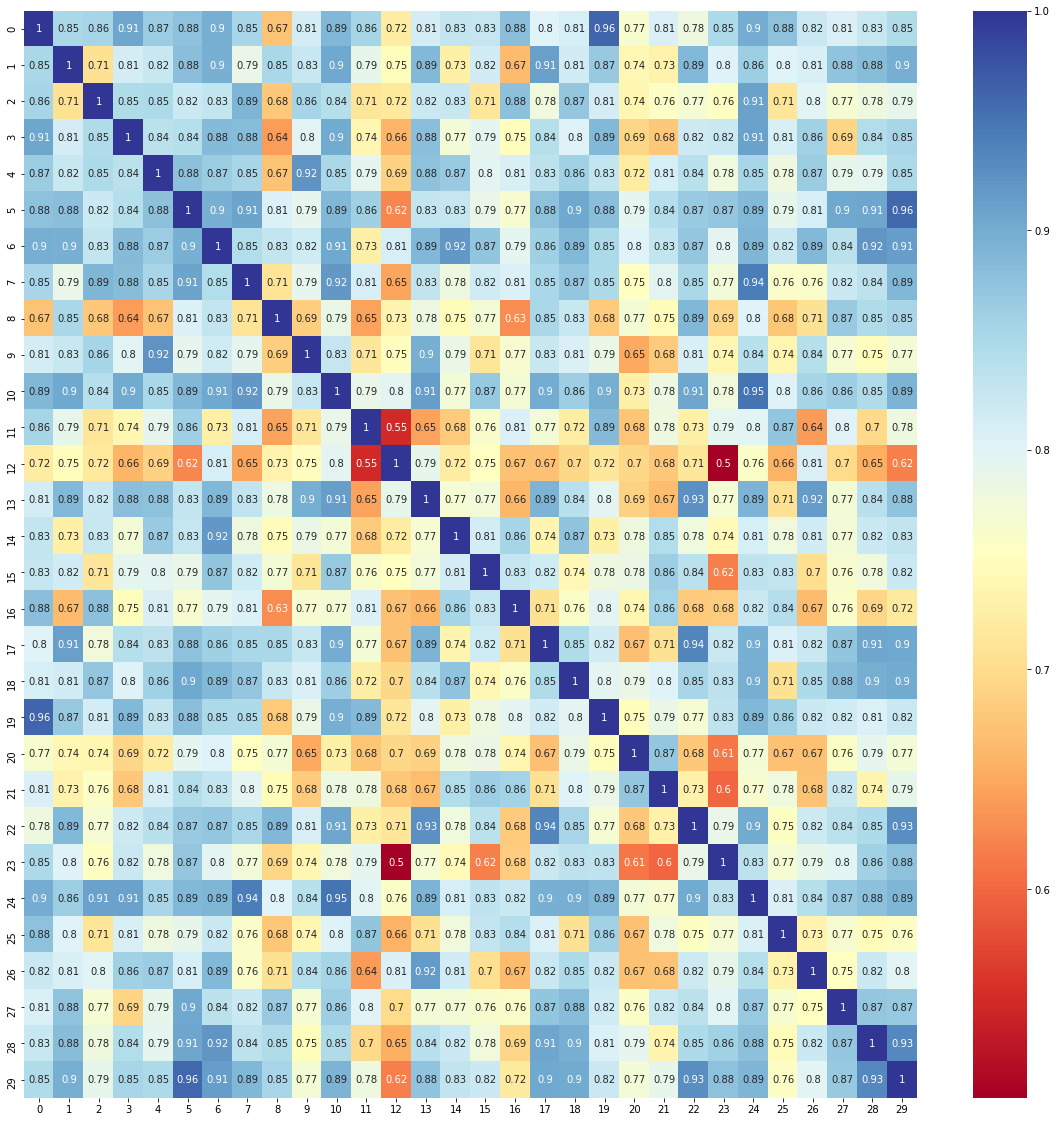

In [5]:
#Heat map to check the dependency of variables
X_corelation = X_train.corr()
X_features = X_corelation.index
plt.figure(figsize=(20,20))
sea.heatmap(X_train[X_features].corr(),annot=True,cmap="RdYlBu")

# Using Principle component Analysis for Dimensional Reduction

In [7]:
#reduce dimensionality using Prinicipal component Analysis
pca = PCA(n_components = 26)
X_train = pca.fit_transform(X_train)
X_valid = pca.transform(X_valid)
X_test=pca.transform(X_test)

# Svm Model with highest Accuracy

In [8]:
# Using SVM model with linear kernel
svm_model = svm.SVC(kernel='linear',degree=1)
svm_model.fit(X_train, y_train.values.ravel()) 
svm_predict = svm_model.predict(X_valid)
print(" SVM Accuracy: ", metrics.accuracy_score(y_valid, svm_predict))

 SVM Accuracy:  0.92


# Other model Performances

In [9]:
#Other model peformances
#k nearest neighbor model
K_neighbor_model = KNeighborsClassifier(n_neighbors = 8).fit(X_train,y_train.values.ravel())
neighbour_predict = K_neighbor_model.predict(X_valid)
print(" k neighbour Accuracy: ", metrics.accuracy_score(y_valid, neighbour_predict))

#xg boost model
xg_model = XGBClassifier().fit(X_train,y_train.values.ravel())
xg_predict =xg_model.predict(X_valid)
print(" xg boost accuracy: ", metrics.accuracy_score(y_valid, xg_predict))

#decision tree model
decision_model= DecisionTreeClassifier(criterion="entropy",max_features=26,random_state=1)
decision_model.fit(X_train,y_train)
decision_predict = decision_model.predict(X_valid)
print("decision tree Accuracy: ", metrics.accuracy_score(y_valid, decision_predict))

# bagging classifier of svm model
bagging_clf= BaggingClassifier(svm.SVC(kernel='linear',degree=1),n_estimators=900,max_samples=30,bootstrap=True,n_jobs=-1)
bagging_clf.fit(X_train, y_train.values.ravel())
bagging_predict = bagging_clf.predict(X_valid)
print(" Bagging Accuracy: ", metrics.accuracy_score(y_valid, bagging_predict))

 k neighbour Accuracy:  0.78
 xg boost accuracy:  0.74
decision tree Accuracy:  0.78
 Bagging Accuracy:  0.88


# Generating Confusion Matrix

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92        25
         1.0       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



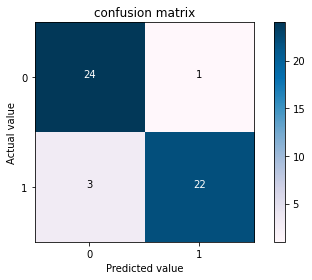

In [10]:
confusion_predict=svm_predict
# Generate confusion metrix
conf_matrix = confusion_matrix(y_valid, confusion_predict, labels=[0,1])
np.set_printoptions(precision=2)

#get classification report which has precision,recall and f1 score
print (classification_report(y_valid, confusion_predict))

#plot confusion matrix
plt.figure()
plt.imshow(conf_matrix,cmap='PuBu')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('Actual value')
plt.xlabel('Predicted value')
plt.tight_layout()
plt.xticks(np.arange(2), [0,1])
plt.yticks(np.arange(2), [0,1])

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] >  conf_matrix.max() / 2. else "black")


# Test set Values

In [12]:
#predict values for x_test
y_values=svm_model.predict(X_test)
np.savetxt("predicted_y_test.csv", y_values, delimiter=",")